100%|██████████| 20000/20000 [00:27<00:00, 723.19it/s] 


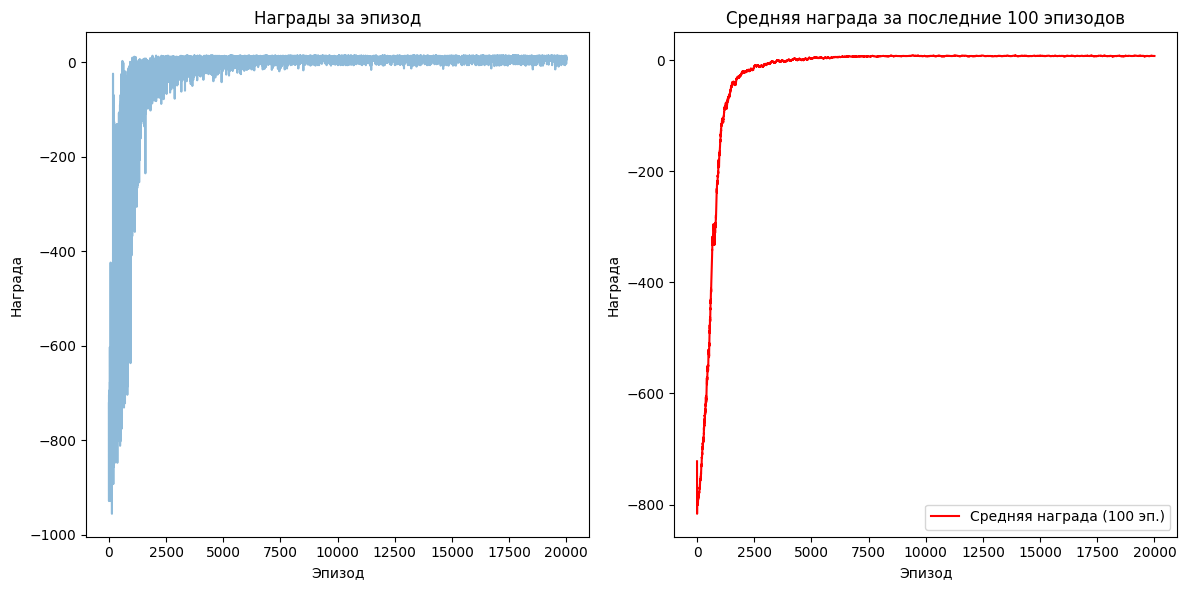


Отчет о обучении:
Общее количество эпизодов: 20000
Финальное значение epsilon: 0.0100
Максимальная награда: 15
Средняя награда за последние 100 эпизодов: 7.41

Результаты тестирования:
Средняя награда при тестировании: 7.80
Минимальная награда при тестировании: 3
Максимальная награда при тестировании: 12


In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
import pickle
from tqdm import tqdm
import os


os.makedirs('taxi_results', exist_ok=True)
env = gym.make('Taxi-v3')

#############################
EPISODES = 20000
ALPHA = 0.1
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.9995
#############################

q_table = np.zeros((env.observation_space.n, env.action_space.n))

rewards = []
avg_rewards = []  # Средняя награда за последние 100 эпизодов
epsilon = EPSILON_START

for episode in tqdm(range(EPISODES)):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + GAMMA * q_table[next_state][best_next_action] * (not done)
        td_error = td_target - q_table[state][action]
        q_table[state][action] += ALPHA * td_error

        total_reward += reward
        state = next_state

    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)


    rewards.append(total_reward)

    # Вычисляем среднюю награду за последние 100 эпизодов
    if episode >= 100:
        avg_reward = np.mean(rewards[-100:])
        avg_rewards.append(avg_reward)
    else:
        avg_rewards.append(np.mean(rewards))


with open('taxi_results/q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards, alpha=0.5, label='Награда за эпизод')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Награды за эпизод')

plt.subplot(1, 2, 2)
plt.plot(avg_rewards, color='red', label='Средняя награда (100 эп.)')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Средняя награда за последние 100 эпизодов')
plt.legend()

plt.tight_layout()
plt.savefig('taxi_results/rewards_plot.png')
plt.show()

print("\nОтчет о обучении:")
print(f"Общее количество эпизодов: {EPISODES}")
print(f"Финальное значение epsilon: {epsilon:.4f}")
print(f"Максимальная награда: {max(rewards)}")
print(f"Средняя награда за последние 100 эпизодов: {avg_rewards[-1]:.2f}")

# Тестирование обученного агента
test_episodes = 10
test_rewards = []

for episode in range(test_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = np.argmax(q_table[state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    test_rewards.append(total_reward)

print("\nРезультаты тестирования:")
print(f"Средняя награда при тестировании: {np.mean(test_rewards):.2f}")
print(f"Минимальная награда при тестировании: {min(test_rewards)}")
print(f"Максимальная награда при тестировании: {max(test_rewards)}")

In [2]:
def run_episode(env, q_table):
    frames = []
    state, _ = env.reset()
    done = False

    while not done:
        frames.append(env.render())

        action = np.argmax(q_table[state])
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    frames.append(env.render())
    return frames


def save_frames_as_gif(frames, path='./taxi_animation.gif'):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path, writer='pillow', fps=10)

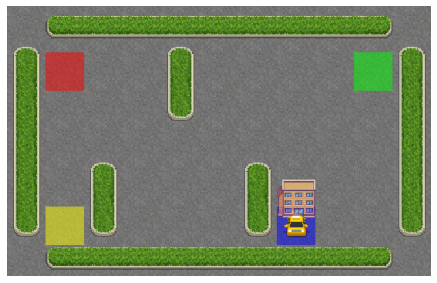

In [3]:
env = gym.make('Taxi-v3', render_mode="rgb_array")
frames = run_episode(env, q_table)
save_frames_as_gif(frames)